In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import sys
sys.path.append('./utils')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats
import rft_reconstruct_traj as rft
from scipy.io import loadmat

In [2]:
mat=h5py.File('../data/Foraging_N2/PNAS2011-DataStitched.mat','r')
refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
frameRate=16.
dt=1/frameRate

masked_ts_w = []
for worm in np.arange(len(tseries_w)):
    ts_w = tseries_w[worm]
    ts_w[0] = ma.masked
    ts_w[-1] = ma.masked
    masked_ts_w.append(ts_w)

n_worms = len(tseries_w)

eigenworms_matrix = np.loadtxt('../data/Foraging_N2/EigenWorms.csv', delimiter=',').astype(np.float32)
thetas_w = ma.array([ts.dot(eigenworms_matrix[:,:5].T) for ts in tseries_w])
thetas_all = ma.vstack(thetas_w)

In [3]:
f = h5py.File('../data/labels_tree/labels_tree.h5','r')
delay = int(np.array(f['delay'])[0])
eigfunctions = np.array(f['eigfunctions'])
final_labels = ma.masked_invalid(np.array(f['final_labels'],dtype=int))
final_labels_mask = np.array(f['final_labels_mask'])
sel = final_labels_mask==1
final_labels[sel] = ma.masked
mlg = f['measures']
measures = []
for k in np.sort(list(mlg.keys())):
    measures.append(np.array(mlg[str(k)]))
labels_tree = np.array(f['labels_tree'],dtype=int)
f.close()

# characterize states

In [4]:
colors_states_ = ['#951622','#E30613','#F06600','#F09900','#312783','#1F77B4','#009FE3']
final_states = ['faststraight','fastscurved','slowdorsal','slowventral','dorsal turns','reversals','turns']
subdiv_dict = {'run':['slow','fast'],'fast':['fast_curved','fast_straight'],'slow':['dorsal','ventral'],
              'pirouette':['dorsal','ventral'],'ventral pirouettes':['reversals','turns']}

In [5]:
kmeans_labels = labels_tree[5,:]
cluster_traj = ma.copy(final_labels)
cluster_traj[~final_labels.mask] = ma.masked_invalid(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj[final_labels.mask] = ma.masked

In [6]:
segments=op_calc.segment_maskedArray(ma.vstack(masked_ts_w),5)
omegas_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
a3s_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])

for t0,tf in segments:
    phi,omega,a3=worm_dyn.compute_phi_omega_a3(ma.vstack(masked_ts_w),t0,tf)
    omegas_all[t0:tf] = omega
    a3s_all[t0:tf] = a3

omegas_all[omegas_all==0]=ma.masked
a3s_all[a3s_all==0]=ma.masked

curvature_all = ma.abs(thetas_all).mean(axis=1)
thetas_sum = thetas_all.sum(axis=1)

In [7]:
kmeans_labels = labels_tree[5,:]
cluster_traj = ma.copy(final_labels)
cluster_traj[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj[final_labels.mask] = ma.masked

In [8]:
msd_sims_state=[]
psd_sims_state=[]
for state_idx in range(7):
    f = h5py.File('../data/msds_psds_states/state_{}.h5'.format(state_idx),'r')
    msd_sims = np.array(f['mu_sims'])
    lags_msd = np.array(f['lags'],dtype=int)
    psd_sims = np.array(f['psd_sims'])
    freq = np.array(f['freqs'])
    f.close()
    msd_sims_state.append(msd_sims)
    psd_sims_state.append(psd_sims)
    print(state_idx)

0
1
2
3
4
5
6


In [9]:
[np.abs(omegas_all[cluster_traj==ks].mean()) for ks in range(7)]

[0.5249792271446683,
 0.6038412596281536,
 0.38206320468097577,
 0.20386304469493202,
 0.05472233231225187,
 0.27945633371988976,
 0.06515211968368971]

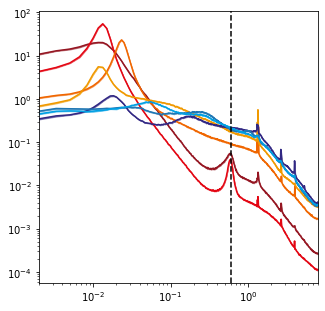

In [10]:
plt.figure(figsize=(5,5))
for state_idx in range(7):
    psd_sims = psd_sims_state[state_idx]
    mean,cil,ciu = stats.bootstrap(psd_sims,n_times=10)
    plt.plot(freq,mean,c=colors_states_[state_idx])
    plt.fill_between(freq,cil,ciu,alpha=.5,color=colors_states_[state_idx])
plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-3,8)
plt.axvline(np.mean(omegas_all[cluster_traj==1].compressed()),ls='--',c='k')
# plt.savefig('bearing_psd.pdf')
plt.show()

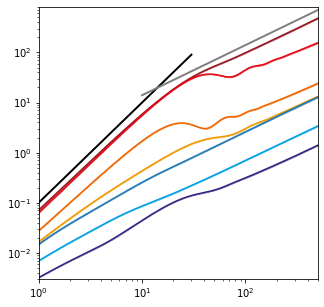

In [11]:
plt.figure(figsize=(5,5))
for state_idx in range(7):
    msd_sims = msd_sims_state[state_idx]
    mean,cil,ciu = stats.bootstrap(msd_sims,n_times=10)
    plt.plot(lags_msd*dt,mean,c=colors_states_[state_idx])
    plt.fill_between(lags_msd*dt,cil,ciu,alpha=.5,color=colors_states_[state_idx])
plt.xscale('log')
plt.yscale('log')
plt.xlim(1,500)
x = np.linspace(1,30)
plt.plot(x,.1*x**2,c='k',lw=2)
x = np.linspace(10,500)
plt.plot(x,1.4*x,c='gray',lw=2)
plt.ylim(3e-3,8e2)
# plt.savefig('msd_states_regimes.pdf')
plt.show()